# COMP4124 Lab 04: RDD Exercises

The aim of this lab is to get some practice with PySpark's RDD API. As mentioned in the lectures, usually we want to use the DataFrame API as it is more heavily optimised. However, there may be times, such as if you are designing a bespoke solution to a data analysis problem, where it may be useful to use the RDD API instead due to the additional flexibility it provides.

This notebook is split into two parts:

* The first part recaps key-value RDDs
* The second part contains exercises for you to complete

The exercises are the same as from the DataFrame Tutorial from 14/02/2025. The only difference is, you should now solve these exercises using the RDD API instead.

## Set-Up

**Install pyspark so can use within the notebook:**

In [ ]:
!pip install pyspark

**Initialise the `SparkSession`:**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Lab04") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
data_path = "/content/drive/My Drive/COMP4124_notebooks/24-25/data/"

In [ ]:
import matplotlib.pyplot as plt

## Recap: Aggregations with RDDs

### Load our data and convert to RDD

Read in our data as a DataFrame to start:

In [ ]:
df = spark.read.csv(data_path+'rooms.csv', header=True, inferSchema=True)
df.show(5)

+--------+----+--------+---------+
|Building|Room|Capacity|Room type|
+--------+----+--------+---------+
|     BSS| A25|     120|   Tiered|
|     BSS| B52|     500|   Tiered|
|      CS| A07|      52|     Flat|
|      CS| A32|     160| Computer|
| Dearing| A34|      80| Computer|
+--------+----+--------+---------+
only showing top 5 rows



Access the underlying RDD of our DataFrame:

In [ ]:
room_rdd = df.rdd
room_rdd

MapPartitionsRDD[18] at javaToPython at NativeMethodAccessorImpl.java:0

In [ ]:
type(room_rdd)

pyspark.rdd.RDD

**What happens if I bring five elements from the RDD back to the driver?**

In [ ]:
room_rdd.take(5)

[Row(Building='BSS', Room='A25', Capacity=120, Room type='Tiered'),
 Row(Building='BSS', Room='B52', Capacity=500, Room type='Tiered'),
 Row(Building='CS', Room='A07', Capacity=52, Room type='Flat'),
 Row(Building='CS', Room='A32', Capacity=160, Room type='Computer'),
 Row(Building='Dearing', Room='A34', Capacity=80, Room type='Computer')]

From the [PySpark docs RDD page](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html):

> "A Resilient Distributed Dataset (RDD), the basic abstraction in Spark. Represents an immutable, partitioned collection of elements that can be operated on in parallel."

The elements in an RDD can be any type we want. In this case, each element in `room_rdd` is a Row, so the code cell above has returned a list of Rows to the driver.



### Aggregations on RDDs

**Get the maximum Capacity from the RDD, and return the value to the driver**

In [ ]:
max_capacity = room_rdd.max(lambda r: r['Capacity'])
max_capacity

Row(Building='BSS', Room='B52', Capacity=500, Room type='Tiered')

Here I have used a *lambda function* to specify which item in each row to look at for computing the maximum.

Is `max_capacity` distributed, or does it exist on the driver?

In [ ]:
type(max_capacity)

pyspark.sql.types.Row

`max_capacity` is just a Row! It is not an RDD or a DataFrame, and has already been returned back to the driver. This indicates that `RDD.max()` is an **action**. How does this compare to the DataFrame aggregations we have seen in previous weeks?

The only thing we might like to do further is index into our returned Row so that `max_capacity` is just the relevant integer, rather than the entire Row.

In [ ]:
max_capacity = room_rdd.max(lambda r: r['Capacity'])['Capacity']
max_capacity

500

In [ ]:
type(max_capacity)

int

### Aggregating values using key-value RDDs

We can use RDDs containing key-value pairs to do aggregations for groups of elements.

**Find the maximum room capacity in each building:**

`room_rdd` contains Rows at the moment so we first need to `map()` this to create an RDD of key-value pairs. We want to group based on Building, so this should be the key. The value we are interested in is the Capacity.

In [ ]:
room_rdd \
  .map(lambda r: (r['Building'],r['Capacity'])) \
  .take(5)

[('BSS', 120), ('BSS', 500), ('CS', 52), ('CS', 160), ('Dearing', 80)]

We can then add in a `reduceByKey()` to aggregate the values for each key ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html)). We need to specify the function to use for the reduce - in our case we are looking for the maximum in each group so we can just use the built-in function `max`.

Hopefully these kinds of *reduce* functions are familiar from the MapReduce paradigm at the start of the module.

In [ ]:
# find the largest room in each building
room_rdd \
  .map(lambda r: (r['Building'],r['Capacity'])) \
  .reduceByKey(max) \
  .collect()

[('BSS', 500),
 ('CS', 160),
 ('Dearing', 80),
 ('Xu Yafen', 67),
 ('Exchange', 290)]

Note that `reduceByKey()` is a transformation - it has created a new RDD. To return the values to the driver we needed to do an action.

RDDs also have a `groupByKey()` function that collects all the values for a key together into a single iterable. Let's try to get a list of all room types for each building.

In [ ]:
# get list of room types for each building
room_rdd \
  .map(lambda r: (r['Building'],r['Room type'])) \
  .groupByKey() \
  .collect()

[('BSS', <pyspark.resultiterable.ResultIterable at 0x7c44dcf0a150>),
 ('CS', <pyspark.resultiterable.ResultIterable at 0x7c44de5be050>),
 ('Dearing', <pyspark.resultiterable.ResultIterable at 0x7c44de5bc450>),
 ('Xu Yafen', <pyspark.resultiterable.ResultIterable at 0x7c44de5bd610>),
 ('Exchange', <pyspark.resultiterable.ResultIterable at 0x7c44dce48290>)]

At the moment, the result is not very readable. We can map the resulting iterable to a list if we want to see the actual values contained within it. The `mapValues()` function allows us to only map over the values while ignoring the keys.

In [ ]:
# get list of room types for each building
room_rdd \
  .map(lambda r: (r['Building'],r['Room type'])) \
  .groupByKey() \
  .mapValues(lambda it: list(it)) \
  .collect()

[('BSS', ['Tiered', 'Tiered']),
 ('CS', ['Flat', 'Computer']),
 ('Dearing', ['Computer', 'Flat', 'Flat']),
 ('Xu Yafen', ['Flat']),
 ('Exchange', ['Tiered', 'Tiered', 'Tiered', 'Flat', 'Flat'])]

We still have duplicates! We can change this by mapping to a Python set first, so only distinct values are kept.

In [ ]:
# get list of room types for each building
room_rdd \
  .map(lambda r: (r['Building'],r['Room type'])) \
  .groupByKey() \
  .mapValues(lambda it: list(set(it))) \
  .collect()

[('BSS', ['Tiered']),
 ('CS', ['Flat', 'Computer']),
 ('Dearing', ['Flat', 'Computer']),
 ('Xu Yafen', ['Flat']),
 ('Exchange', ['Flat', 'Tiered'])]

This has given us the result we wanted. However, `groupByKey()` is generally less efficient than `reduceByKey()`. This is because Spark is able to combine values within each partition before shuffling data around with `reduceByKey()` ([see the docs for more information](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html)). If our operation meets the criteria for a reduce function, then using `reduceByKey()` is generally better to use.

As a reminder, the requirements for a reduce function are that it is associative and commutative. Set operations such as intersection and union meet this criteria. We can therefore rewrite the above using `reduceByKey()`. There are two changes we need to make:
* In our first `.map()`, we need to put the room type inside a set - in Python we can do this by putting `{}` around our item. This is so that each value is a collection rather than a single item, and can subsequently be reduced as collections in our reduce function.
* We replace `groupByKey()` with `reduceByKey()` and use the union of sets here to join sets together. Because we are operating with sets, we only keep distinct values.

In [ ]:
# get list of room types for each building
room_rdd \
  .map(lambda r: (r['Building'],{r['Room type']})) \
  .reduceByKey(lambda x,y: x.union(y)) \
  .mapValues(lambda x: list(x)) \
  .collect()

[('BSS', ['Tiered']),
 ('CS', ['Flat', 'Computer']),
 ('Dearing', ['Flat', 'Computer']),
 ('Xu Yafen', ['Flat']),
 ('Exchange', ['Flat', 'Tiered'])]

## Exercises

### Exercise 1: Histogram of word repetitions

Calculate a histogram of word repetitions for the file `quixote.txt`. I.e. calculate the number of words that are repeated X times:

* 1 time - 3 words
* 2 times - 10 words
* 3 times - 7 words
* And so on...

All the processing should be done with **RDD operations**. The resulting RDD should be ordered by **the number of times** (ascending), and the top 20 rows only brought back to the driver as a list. Blank lines should be ignored.

Let's load the data and convert the DataFrame to an RDD.

In [ ]:
df_text = spark.read.text(data_path+'quixote.txt')
df_text.show(5)

+--------------------+
|               value|
+--------------------+
|                    |
|The Project Guten...|
|                    |
|This eBook is for...|
|almost no restric...|
+--------------------+
only showing top 5 rows



In [ ]:
rdd_text = df_text.rdd
rdd_text.take(5)

[Row(value=''),
 Row(value='The Project Gutenberg EBook of The History of Don Quixote by Miguel de Cervantes'),
 Row(value=''),
 Row(value='This eBook is for the use of anyone anywhere at no cost and with'),
 Row(value='almost no restrictions whatsoever.  You may copy it, give it away or')]

Each item in the RDD is a Row containing a single field called `value`. There is not much point keeping these as Rows in this case as we are not working with structured data, so I am going to `map()` each Row to just the string value.

In [ ]:
rdd_text = df_text.rdd \
  .map(lambda r: r['value'])
rdd_text.take(5)

['',
 'The Project Gutenberg EBook of The History of Don Quixote by Miguel de Cervantes',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or']

The first step of this is to do a word count. The code to do this with RDDs is below.

<font color='blue'>**Task:** Run the below code to create an RDD containing the word count for each word in the text. Make sure you understand what is happening at each step of it - and refer to the PySpark **RDD** docs if you are unclear on what some of the functions are doing!
</font>

In [ ]:
word_count_rdd = rdd_text.flatMap(lambda x: x.split(' ')) \
  .filter(lambda x: x != '') \
  .map(lambda x: (x, 1)) \
  .reduceByKey(lambda x, y: x + y)

word_count_rdd.take(5)

[('The', 849), ('Project', 79), ('Gutenberg', 22), ('EBook', 2), ('of', 12866)]

The second step is to then count the number of occurrences of each word count.

<font color='blue'>**Task:** Write the code to complete the histogram exercise. You might like to follow the below steps, but there are various different functions you could use to achieve this.
* Map `word_count_rdd` to create another key-value pair RDD. You will need to identify an appropriate key and value to use.
* Use `reduceByKey()` to aggregate the values for each key. You will need to identify an appropriate function to use for the reduction.
* Sort the RDD by the *number of times*, i.e. by the key.
* Return only the first 20 elements to the driver.
</font>



In [ ]:
hist_rdd = word_count_rdd \
  .map(lambda k_v: (k_v[1], 1)) \
  .reduceByKey(lambda x, y: x + y) \
  .sortByKey()

hist_rdd.take(20)

[(1, 17817),
 (2, 5146),
 (3, 2291),
 (4, 1520),
 (5, 998),
 (6, 737),
 (7, 589),
 (8, 439),
 (9, 333),
 (10, 288),
 (11, 227),
 (12, 216),
 (13, 184),
 (14, 199),
 (15, 143),
 (16, 128),
 (17, 109),
 (18, 97),
 (19, 91),
 (20, 90)]

### Exercise 2: Aggregations on Red Fox GPS Traces

For Exercise 2, we will be using a dataset of GPS traces of red foxes. A version of the dataset with some columns already removed, `red_foxes_cleaned.csv` is available on Moodle. The original data was downloaded from Movebank, available [here](https://www.movebank.org/cms/webapp?gwt_fragment=page%3Dstudies%2Cpath%3Dstudy3179890710).

> Porteus TA, Short MJ, Hoodless AN, Reynolds JC. 2024. Data from: Study "Red Fox (Vulpes vulpes) in UK wet grasslands". Movebank Data Repository. https://doi.org/10.5441/001/1.304

In [ ]:
fox_df = spark.read.csv(data_path+'red_foxes_cleaned.csv', header=True)
fox_df.show(10, truncate=False)

+-----------+-----------------------+-------------+------------+--------------------+---------------------------+
|event-id   |timestamp              |location-long|location-lat|tag-local-identifier|individual-local-identifier|
+-----------+-----------------------+-------------+------------+--------------------+---------------------------+
|30910902966|2016-04-16 05:29:00.000|-1.7649454   |51.05246    |5546                |B16F01                     |
|30910902967|2016-04-16 05:40:00.000|-1.764728333 |51.05456833 |5546                |B16F01                     |
|30910902968|2016-04-16 05:50:00.000|-1.764713333 |51.0544     |5546                |B16F01                     |
|30910902969|2016-04-16 06:00:00.000|-1.764996667 |51.05456    |5546                |B16F01                     |
|30910902970|2016-04-16 06:10:00.000|-1.764318333 |51.0542     |5546                |B16F01                     |
|30910902971|2016-04-16 06:20:00.000|-1.764558333 |51.054255   |5546                |B16

As a reminder, the attributes have the following meanings:

* `event-id`: unique identifier for this record
* `timestamp`: timestamp of the record
* `location-long`: longitude
* `location-lat`: latitude
* `tag-local-identifier`: identifier of the tag used to track a fox
* `individual-local-identifier`: identifier of the fox

I am going to cast the columns to the appropriate types before we convert to an RDD.

In [ ]:
import pyspark.sql.functions as F
fox_df = fox_df \
  .withColumn('timestamp',F.to_timestamp(fox_df.timestamp)) \
  .withColumn('location-long',F.col('location-long').cast('float')) \
  .withColumn('location-lat',F.col('location-lat').cast('float'))
fox_df.printSchema()

root
 |-- event-id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- location-long: float (nullable = true)
 |-- location-lat: float (nullable = true)
 |-- tag-local-identifier: string (nullable = true)
 |-- individual-local-identifier: string (nullable = true)



Convert the DataFrame to an RDD:

In [ ]:
fox_rdd = fox_df.rdd
fox_rdd.take(5)

[Row(event-id='30910902966', timestamp=datetime.datetime(2016, 4, 16, 5, 29), location-long=-1.764945387840271, location-lat=51.052459716796875, tag-local-identifier='5546', individual-local-identifier='B16F01'),
 Row(event-id='30910902967', timestamp=datetime.datetime(2016, 4, 16, 5, 40), location-long=-1.764728307723999, location-lat=51.054569244384766, tag-local-identifier='5546', individual-local-identifier='B16F01'),
 Row(event-id='30910902968', timestamp=datetime.datetime(2016, 4, 16, 5, 50), location-long=-1.7647132873535156, location-lat=51.05440139770508, tag-local-identifier='5546', individual-local-identifier='B16F01'),
 Row(event-id='30910902969', timestamp=datetime.datetime(2016, 4, 16, 6, 0), location-long=-1.7649966478347778, location-lat=51.054561614990234, tag-local-identifier='5546', individual-local-identifier='B16F01'),
 Row(event-id='30910902970', timestamp=datetime.datetime(2016, 4, 16, 6, 10), location-long=-1.7643183469772339, location-lat=51.05419921875, tag-lo

#### Exercise 2a

**Find the five foxes tracked over the longest time period. The tracking duration should be reported in *days*. Return the five fox identifiers and their respective tracking durations as a list, sorted in descending order of tracking duration.**

<font color='blue'>**Task:** Complete the code for Exercise 2a in the box below using the RDD API.
</font>

In [ ]:
duration_rdd = fox_rdd \
  .map(lambda r: (r['individual-local-identifier'],r['timestamp'])) \
  .groupByKey() \
  .mapValues(lambda it: (max(it)-min(it)).total_seconds()/86400) \
  .map(lambda p: (p[1],p[0])) \
  .sortByKey(ascending=False)

duration_rdd.take(5)

[(87.84444444444445, 'B16M02'),
 (84.38333333333334, 'S19F01'),
 (80.58541666666666, 'S19M02'),
 (79.16527777777777, 'S18M02'),
 (66.25277777777778, 'B16M03')]

#### Exercise 2b

**How many foxes were tracked on each day in the dataset? Produce a bar chart to display this.**

<font color='blue'>**Task:** Complete the code for Exercise 2b in the box below using the RDD API.
</font>

In [ ]:
day_rdd = fox_rdd \
  .map(lambda r: (r['timestamp'].date(),[r['individual-local-identifier']])) \
  .reduceByKey(lambda list1,list2: set(list1).union(list2)) \
  .mapValues(lambda s: len(s))

days_lst = day_rdd.collect()

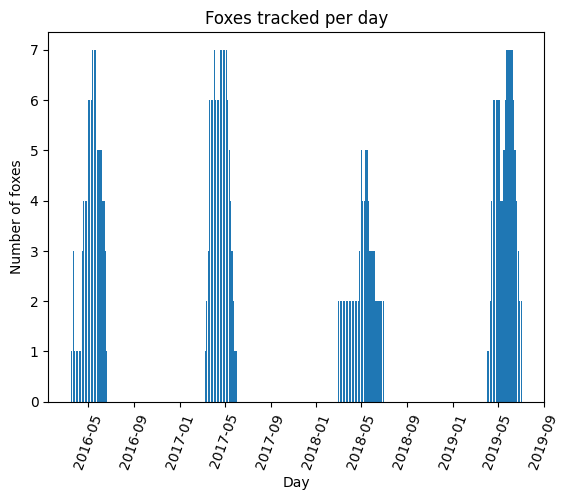

In [ ]:
x_vals,y_vals = zip(*days_lst)
plt.bar(x_vals, y_vals)
plt.title('Foxes tracked per day')
plt.xlabel('Day')
plt.ylabel('Number of foxes')
plt.xticks(rotation=70)
plt.show()

## Summary

Hopefully this lab has shown you the differences between working with DataFrames, and working with RDDs directly.

* With DataFrames, our data is restricted to being in columns of a particular type. The DataFrame API gives us **many** functions for working with columns of different types - these functions are optimised and highly efficient, and so should be preferred over working with RDDs.
* With RDDs, we have more flexibility in how we work with our data. There are no columns so we have to write the code to work with the values ourselves, rather than operating at a column level. However, because Spark does not have so much knowledge on the type of the data and the operations, there is a lot less optimisation that can occur.

**It is good practice to stop the underlying SparkContext when we are done**

In [ ]:
spark.stop()

In [ ]:
spark